In [259]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [260]:
#change the current directory to the path where the given file is residing
import os
os.chdir('/content/mydrive/My Drive/LTFS FinHack3')
os.getcwd()

'/content/mydrive/My Drive/LTFS FinHack3'

Import necessary libraries.

In [428]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from datetime import datetime, timedelta
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Read the training dataset and display the header details

In [293]:
train_df = pd.read_excel('train_Data.xlsx')

train_df.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,350000.0,10500.0,2012-03-31,2016-02-15,2012-03-31,4681175,1062,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0,No Top-up Service
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,519728.0,38300.0,2017-06-17,2023-02-10,2017-06-17,25328146,1060,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0,12-18 Months
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,400000.0,11600.0,2013-11-29,2017-11-10,2013-11-29,13021591,1060,25094,80.92,M,24.0,20833.33,ASHOK NAGAR,MADHYA PRADESH,473335.0,> 48 Months
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,440000.0,15000.0,2011-12-08,2015-07-05,2011-12-08,3291320,1046,21853,71.05,M,56.0,27313.67,BILASPUR,CHATTISGARH,495442.0,36-48 Months


Display the information about the training dataset.

In [294]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128655 entries, 0 to 128654
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ID               128655 non-null  int64         
 1   Frequency        128655 non-null  object        
 2   InstlmentMode    128655 non-null  object        
 3   LoanStatus       128655 non-null  object        
 4   PaymentMode      128655 non-null  object        
 5   BranchID         128655 non-null  int64         
 6   Area             117002 non-null  object        
 7   Tenure           128655 non-null  int64         
 8   AssetCost        128655 non-null  int64         
 9   AmountFinance    128655 non-null  float64       
 10  DisbursalAmount  128655 non-null  float64       
 11  EMI              128655 non-null  float64       
 12  DisbursalDate    128655 non-null  datetime64[ns]
 13  MaturityDAte     128654 non-null  datetime64[ns]
 14  AuthDate         128

Before starting the imputation process, we need to figure out which are the fields containing null values.

In [295]:
train_df.isnull().any()

ID                 False
Frequency          False
InstlmentMode      False
LoanStatus         False
PaymentMode        False
BranchID           False
Area                True
Tenure             False
AssetCost          False
AmountFinance      False
DisbursalAmount    False
EMI                False
DisbursalDate      False
MaturityDAte        True
AuthDate           False
AssetID            False
ManufacturerID     False
SupplierID         False
LTV                False
SEX                 True
AGE                 True
MonthlyIncome       True
City                True
State              False
ZiPCODE             True
Top-up Month       False
dtype: bool

The fields 'Area', ,'MaturityDAte', 'SEX', 'AGE', 'MonthlyIncome', 'City' and 'ZiPCODE' contain null values.

In [296]:
#Let's get the count of null values to check if it is relevant one to perform the imputation
train_df.isnull().sum()[train_df.isnull().sum() > 0]

Area             11653
MaturityDAte         1
SEX                 59
AGE                 59
MonthlyIncome      234
City             11256
ZiPCODE            372
dtype: int64

Conclusion: The features 'Area' & 'City' have more null values when compared to other variables with null.

In [297]:
#print the shape of the training dataset
print('The shape of the training dataset:', train_df.shape)

The shape of the training dataset: (128655, 26)


We can drop the row with a null value for 'MaturityDAte', as there is only 1 record with empty values.

In [298]:
train_df[train_df['MaturityDAte'].isna()]

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
53392,57606,Monthly,Arrear,Closed,Billed,263,MANDSAUR,45,495000,400000.0,400000.0,0.0,2013-03-15,NaT,2013-03-16,9510810,1046,55150,80.81,M,43.0,41666.67,MANDSAUR,MADHYA PRADESH,458880.0,No Top-up Service


In [299]:
#drop the value
maturity_index = train_df[train_df['MaturityDAte'].isna()].index.values

In [300]:
maturity_index

array([53392])

In [301]:
print('The shape of training dataset before dropping the index:', train_df.shape)

The shape of training dataset before dropping the index: (128655, 26)


In [302]:
train_df.drop(maturity_index, inplace=True)

In [303]:
print('The shape of training dataset after dropping the index:', train_df.shape)

The shape of training dataset after dropping the index: (128654, 26)


In [304]:
missing_count = pd.DataFrame(train_df.isnull().sum()[train_df.isnull().sum() > 0], columns=['Null_counts'])

In [305]:
missing_count

,Null_counts
Area,11653
SEX,59
AGE,59
MonthlyIncome,234
City,11256
ZiPCODE,372


In [306]:
#Let's see the percentage of the missing values in each variable when compared to the total count
missing_count['Null%'] = missing_count*100/train_df.shape[0]
missing_count


,Null_counts,Null%
Area,11653,9.057627
SEX,59,0.045859
AGE,59,0.045859
MonthlyIncome,234,0.181883
City,11256,8.749048
ZiPCODE,372,0.289148


Area has the maximum percentage in the missing values almost 9%.Except 'MonthlyIncome' all of the data are categorical.

In [307]:
#now check if more than one fields carry null values at the same time.
null_df = pd.DataFrame([], columns=['feature_name1', 'feature_name2', 'null_count'])
index = 0

null_cols = ['Area', 'SEX', 'AGE', 'MonthlyIncome', 'City', 'ZiPCODE']
for i in null_cols:
  for j in null_cols:
    if i != j:
      #check whether the combination is already present, if yes then no updates required
      count = null_df[(null_df['feature_name1'] == j) & (null_df['feature_name2'] == i)].count().values
      if count[0]!= 1:
        null_df.loc[index, 'feature_name1'] = i
        null_df.loc[index, 'feature_name2'] = j
        null_df.loc[index, 'null_count'] = train_df[train_df[i].isna()][j].isna().sum()
        index += 1    


In [308]:
null_df

,feature_name1,feature_name2,null_count
0,Area,SEX,5
1,Area,AGE,5
2,Area,MonthlyIncome,24
3,Area,City,1505
4,Area,ZiPCODE,48
5,SEX,AGE,59
6,SEX,MonthlyIncome,53
7,SEX,City,3
8,SEX,ZiPCODE,1
9,AGE,MonthlyIncome,53


One notable observation here is the fields 'Area', 'City' and 'ZiPCODE' are all interlinked. Let's apply chi-squared test to see the correlation between these variables. If they have strong dependencies, then only one feature can be retained and rest of them can be dropped.

In [309]:
#from the input file, we can find two more variables related to location and they are State and BranchID
obj_cols = ['Area', 'City', 'ZiPCODE', 'State', 'BranchID', 'Top-up Month']


chisquare_df = pd.DataFrame([], columns=obj_cols, index = obj_cols)
#calculate the pvalue from chisquare stats
for i in obj_cols:            
    for j in obj_cols:            
        cont = pd.crosstab(train_df[i], train_df[j])  
        chisquare_df.loc[i,j] = chi2_contingency(cont)[1]        

chisquare_df

,Area,City,ZiPCODE,State,BranchID,Top-up Month
Area,0,0,0,0,0,0
City,0,0,0,0,0,0
ZiPCODE,0,0,0,0,0,0
State,0,0,0,0,0,0
BranchID,0,0,0,0,0,0
Top-up Month,0,0,0,0,0,0


All of the features are strongly correlated with the target variable 'Top-up Month'. On top of that, the predictors 'Area', 'City' and 'ZiPCODE' are strongly related to one another.  

So it would be suffice to retain only one rather that all three. 

In [310]:
#Now comes the question of which one to retain. For that we need to group the variables and see how unique the values are.
print('unique count of  Area:', train_df['Area'].nunique())
print('unique count for City:', train_df['City'].nunique())
print('unique count for ZiPCODE:', train_df['ZiPCODE'].nunique())
print('unique count for State:', train_df['State'].nunique())
print('unique count for BranchID:', train_df['BranchID'].nunique())

unique count of  Area: 92
unique count for City: 488
unique count for ZiPCODE: 9123
unique count for State: 22
unique count for BranchID: 189


We know that when there are too many values involved in the categorical variable, then the model tends to overfit. 

Let's take the ZiPCODE, we do not have sufficient records for all the zipcodes(recollecting the feature and the input training sample ratio)

In [311]:
#displaying how the data counts are spread across various zipcodes
zip_count = pd.DataFrame(train_df['ZiPCODE'].value_counts())

In [312]:
zip_count[zip_count['ZiPCODE'] < 20]

,ZiPCODE
136034.0,19
505455.0,19
284203.0,19
712601.0,19
844122.0,19
...,...
583234.0,1
583233.0,1
583215.0,1
244104.0,1


Out of 9123 records 7354 rows are having very small values with a cutoff of 20. So definitely ZipCode is not the right choice as incorporating the variable will overfit the data.

In [313]:
#we repeat the same logic for Area, City, State and BranchID
City_count = pd.DataFrame(train_df['City'].value_counts())
City_count[City_count['City'] < 20]

,City
JHABUA,19
RAMPURHAT,19
ALIGARH,19
MANVI,18
GADCHIROLI,18
...,...
Cuttack,1
SECUNDARABAD,1
MUZAFFARNAGAR,1
GODDA,1


Again out of 488 records, 153 has less number of training instances. 

In [314]:
State_count = pd.DataFrame(train_df['State'].value_counts())
State_count

,State
MADHYA PRADESH,19121
ANDHRA PRADESH,18629
UTTAR PRADESH,14449
KARNATAKA,11569
GUJARAT,10088
RAJASTHAN,9668
MAHARASHTRA,9083
HARYANA,9060
PUNJAB,6420
WEST BENGAL,5557


Finally we can better go with the state which has some desirable counts. 

Note: There is a another approach of handling low occurence values (i.e) via binning where we combine the least frequent values into another category. In this case, we can place the states starting from 'Himachal Pradesh' till 'Tamil Nadu' in the low occurence bin. 

In [315]:
#Lets drop the fields Area, City, ZiPCODE, BranchID and ID
train_df.drop(['Area', 'City', 'ZiPCODE', 'BranchID', 'ID'], axis=1, inplace=True)

In [316]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128654 entries, 0 to 128654
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Frequency        128654 non-null  object        
 1   InstlmentMode    128654 non-null  object        
 2   LoanStatus       128654 non-null  object        
 3   PaymentMode      128654 non-null  object        
 4   Tenure           128654 non-null  int64         
 5   AssetCost        128654 non-null  int64         
 6   AmountFinance    128654 non-null  float64       
 7   DisbursalAmount  128654 non-null  float64       
 8   EMI              128654 non-null  float64       
 9   DisbursalDate    128654 non-null  datetime64[ns]
 10  MaturityDAte     128654 non-null  datetime64[ns]
 11  AuthDate         128654 non-null  datetime64[ns]
 12  AssetID          128654 non-null  int64         
 13  ManufacturerID   128654 non-null  int64         
 14  SupplierID       128

In [317]:
#lets try to fill in the data for AGE, SEX and MonthlyIncome
train_df['SEX'].unique()

array(['M', nan, 'F'], dtype=object)

In [318]:
train_df['SEX'].value_counts()

M    122143
F      6452
Name: SEX, dtype: int64

In [319]:
#we have some date fields in the file (i.e) DisbursalDate, MaturityDAte and AuthDate
#let's convert them into meaningful information, one way to form a pattern is finding the difference between the dates

#we can find the difference between disbursal data and maturity date
#check whether any records have disbursal date greater than the maturity date
train_df[train_df['DisbursalDate'] > train_df['MaturityDAte']]

,Frequency,InstlmentMode,LoanStatus,PaymentMode,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,State,Top-up Month


None of the records satisfy the condition.

In [358]:
train_df['maturity_disburs'] = (train_df['MaturityDAte'] - train_df['DisbursalDate']).dt.days
train_df['maturity_Auth'] = (train_df['MaturityDAte'] - train_df['AuthDate']).dt.days


In [360]:
#we can drop 'MaturityDAte', 'DisbursalDate' and 'AuthDate'
train_df.drop(['MaturityDAte', 'DisbursalDate', 'AuthDate'], axis=1, inplace=True)

In [362]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128654 entries, 0 to 128654
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Frequency         128654 non-null  object 
 1   InstlmentMode     128654 non-null  object 
 2   LoanStatus        128654 non-null  object 
 3   PaymentMode       128654 non-null  object 
 4   Tenure            128654 non-null  int64  
 5   AssetCost         128654 non-null  int64  
 6   AmountFinance     128654 non-null  float64
 7   DisbursalAmount   128654 non-null  float64
 8   EMI               128654 non-null  float64
 9   AssetID           128654 non-null  int64  
 10  ManufacturerID    128654 non-null  int64  
 11  SupplierID        128654 non-null  int64  
 12  LTV               128654 non-null  float64
 13  SEX               128595 non-null  object 
 14  AGE               128595 non-null  float64
 15  MonthlyIncome     128420 non-null  float64
 16  State             12

In [364]:
#There are some ID fields , lets see wether they are meaningful
print('unique values in the AssetID field:', train_df['AssetID'].nunique())
print('unique values in the ManufacturerID field:', train_df['ManufacturerID'].nunique())
print('unique values in the SupplierID field:', train_df['SupplierID'].nunique())

unique values in the AssetID field: 128654
unique values in the ManufacturerID field: 10
unique values in the SupplierID field: 4539


In [366]:
count = train_df['SupplierID'].value_counts()
count[count < 2]

58604     1
85017     1
138503    1
37282     1
140533    1
         ..
125748    1
105362    1
41757     1
140389    1
137117    1
Name: SupplierID, Length: 711, dtype: int64

There are 711 records with SupplierID with values '1'. So we can drop it as there is no sufficient data for each supplier id. 

Asset ID looks like a running sequence number generated for each record, this can also be discarded. 

In [370]:
#retaining only manufacturer ID and dropping AssetID and SupplierID
train_df.drop(['SupplierID', 'AssetID'], axis=1, inplace=True)

In [372]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128654 entries, 0 to 128654
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Frequency         128654 non-null  object 
 1   InstlmentMode     128654 non-null  object 
 2   LoanStatus        128654 non-null  object 
 3   PaymentMode       128654 non-null  object 
 4   Tenure            128654 non-null  int64  
 5   AssetCost         128654 non-null  int64  
 6   AmountFinance     128654 non-null  float64
 7   DisbursalAmount   128654 non-null  float64
 8   EMI               128654 non-null  float64
 9   ManufacturerID    128654 non-null  int64  
 10  LTV               128654 non-null  float64
 11  SEX               128595 non-null  object 
 12  AGE               128595 non-null  float64
 13  MonthlyIncome     128420 non-null  float64
 14  State             128654 non-null  object 
 15  Top-up Month      128654 non-null  object 
 16  maturity_disburs  12

In [391]:
#let's find the correlation between the variables

num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
obj_cols = train_df.select_dtypes(include='object').columns

chisquare_df = pd.DataFrame([], columns=obj_cols, index = obj_cols)
#calculate the pvalue from chisquare stats
for i in obj_cols:            
    for j in obj_cols:            
        cont = pd.crosstab(train_df[i], train_df[j])  
        chisquare_df.loc[i,j] = chi2_contingency(cont)[1]        

chisquare_df

,Frequency,InstlmentMode,LoanStatus,PaymentMode,SEX,State,Topup
Frequency,0,0,0,0,6.54799e-78,0,0
InstlmentMode,0,0,0.877374,0,0.667544,0,1.48663e-31
LoanStatus,0,0.877374,0,0,5.18031e-70,0,0
PaymentMode,0,0,0,0,6.57439e-277,0,0
SEX,6.54799e-78,0.667544,5.18031e-70,6.57439e-277,0,0,4.42296e-40
State,0,0,0,0,0,0,0
Topup,0,1.48663e-31,0,0,4.42296e-40,0,0


In [392]:
train_df.columns = ['Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode', 'Tenure',
       'AssetCost', 'AmountFinance', 'DisbursalAmount', 'EMI',
       'ManufacturerID', 'LTV', 'SEX', 'AGE', 'MonthlyIncome', 'State',
       'Topup', 'maturity_disburs', 'maturity_Auth']

In [393]:
#using oneway anova, we can find the relation between the continuous and discrete variable
anova_result = pd.DataFrame([])
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
obj_cols = train_df.select_dtypes(include='object').columns

#applying anova test for continuous variable and discrete variables
for i in num_cols:
    for j in obj_cols:        
        model = ols(i+' ~ C('+j+')', train_df).fit()
        anova_result.loc[i,j] = sm.stats.anova_lm(model,typ=1).iloc[0]['PR(>F)']
        
anova_result

,Frequency,InstlmentMode,LoanStatus,PaymentMode,SEX,State,Topup
Tenure,0.000000e+00,2.180266e-16,0.000000e+00,3.725349e-143,4.674800e-04,0.00000,4.769020e-148
AssetCost,0.000000e+00,3.726745e-27,0.000000e+00,0.000000e+00,2.671591e-41,0.00000,4.594715e-196
AmountFinance,0.000000e+00,1.180110e-16,0.000000e+00,0.000000e+00,1.079634e-43,0.00000,0.000000e+00
DisbursalAmount,0.000000e+00,1.260831e-18,0.000000e+00,0.000000e+00,1.821062e-43,0.00000,0.000000e+00
EMI,0.000000e+00,0.000000e+00,1.383611e-02,0.000000e+00,2.402796e-05,0.00000,5.331581e-57
ManufacturerID,1.274776e-29,2.869483e-30,1.812661e-02,4.941458e-11,5.191577e-01,0.00000,1.261373e-06
LTV,0.000000e+00,3.920699e-27,0.000000e+00,0.000000e+00,9.759461e-09,0.00000,7.279570e-287
AGE,5.463808e-166,1.692776e-26,1.230891e-92,1.378557e-49,1.694797e-117,0.00000,3.797218e-13
MonthlyIncome,1.251072e-01,5.883305e-01,1.587327e-02,5.404446e-01,9.177333e-01,0.89842,9.997929e-01
maturity_disburs,0.000000e+00,4.722034e-74,0.000000e+00,0.000000e+00,5.949686e-02,0.00000,0.000000e+00


'AGE' & 'SEX' are strongly correlated.

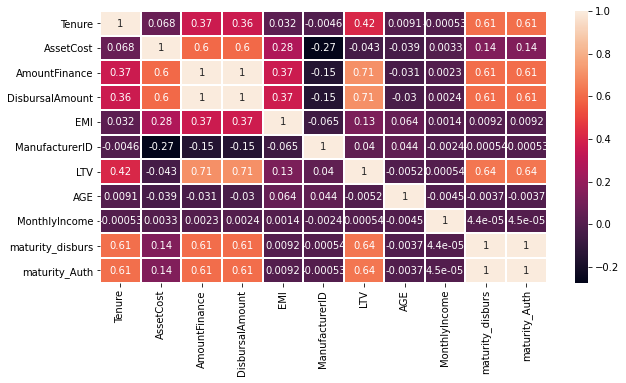

In [400]:
plt.figure(figsize=(10,5))
sns.heatmap(train_df.corr(), linewidth=1, annot=True)

1) 'AmountFinance' & 'DisbursalAmount' are 100% correlated. So we can drop 'AmountFinance'.

2) 'maturity_disburs' & 'maturity_Auth' are 100% correlated. So we can drop 'maturity_Auth'.

In [403]:
train_df.drop(['AmountFinance', 'maturity_Auth'], axis=1, inplace=True)

In [404]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128654 entries, 0 to 128654
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Frequency         128654 non-null  object 
 1   InstlmentMode     128654 non-null  object 
 2   LoanStatus        128654 non-null  object 
 3   PaymentMode       128654 non-null  object 
 4   Tenure            128654 non-null  int64  
 5   AssetCost         128654 non-null  int64  
 6   DisbursalAmount   128654 non-null  float64
 7   EMI               128654 non-null  float64
 8   ManufacturerID    128654 non-null  int64  
 9   LTV               128654 non-null  float64
 10  SEX               128595 non-null  object 
 11  AGE               128595 non-null  float64
 12  MonthlyIncome     128420 non-null  float64
 13  State             128654 non-null  object 
 14  Topup             128654 non-null  object 
 15  maturity_disburs  128654 non-null  int64  
dtypes: float64(5), int64

In [406]:
#we will be using iterative imputer to impute the values
iter = IterativeImputer()

!!! Important Note !!! whenever we do imputation, the target variable should always be dropped.

In [409]:
train_df.drop('Topup', axis=1, inplace=True)

In [411]:
#before giving the values to the iterative imputer, we need to convert the categorical into one hot encoded values
#this time we will use pd.get_dummies to achieve the same since we are using only training data
#But usually one hot encoder is recommended, since it has fit and transform functions
new_df = pd.get_dummies(train_df, drop_first=True)

In [413]:
iter.fit(new_df)

IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=None,
                 sample_posterior=False, skip_complete=False, tol=0.001,
                 verbose=0)

In [416]:
finalised_df = pd.DataFrame(iter.transform(new_df), columns=new_df.columns)

In [430]:
finalised_df['SEX_M'] = np.round(finalised_df['SEX_M'])
finalised_df['AGE'] = np.round(finalised_df['AGE'])

In [431]:
finalised_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128654 entries, 0 to 128653
Data columns (total 46 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Tenure                        128654 non-null  float64
 1   AssetCost                     128654 non-null  float64
 2   DisbursalAmount               128654 non-null  float64
 3   EMI                           128654 non-null  float64
 4   ManufacturerID                128654 non-null  float64
 5   LTV                           128654 non-null  float64
 6   AGE                           128654 non-null  float64
 7   MonthlyIncome                 128654 non-null  float64
 8   maturity_disburs              128654 non-null  float64
 9   Frequency_Half Yearly         128654 non-null  float64
 10  Frequency_Monthly             128654 non-null  float64
 11  Frequency_Quatrly             128654 non-null  float64
 12  InstlmentMode_Arrear          128654 non-nul

In [432]:
finalised_df.isna().sum()

Tenure                          0
AssetCost                       0
DisbursalAmount                 0
EMI                             0
ManufacturerID                  0
LTV                             0
AGE                             0
MonthlyIncome                   0
maturity_disburs                0
Frequency_Half Yearly           0
Frequency_Monthly               0
Frequency_Quatrly               0
InstlmentMode_Arrear            0
LoanStatus_Closed               0
PaymentMode_Billed              0
PaymentMode_Cheque              0
PaymentMode_Direct Debit        0
PaymentMode_ECS                 0
PaymentMode_ECS Reject          0
PaymentMode_Escrow              0
PaymentMode_PDC                 0
PaymentMode_PDC Reject          0
PaymentMode_PDC_E               0
PaymentMode_SI Reject           0
SEX_M                           0
State_ASSAM                     0
State_BIHAR                     0
State_CHANDIGARH                0
State_CHATTISGARH               0
State_DADRA AN